## Tutorial #5: Applying Machine Learning Methods to EEG Data on Group Level

In this tutorial, we are performing the same classification tasks in Tutorial-4, but this time the analysis is done at the group level, considering EEG data from a group of participants.

##### Dataset: 
The the previous tutorial data of the only one participant in 'Emotion-Antecedent Appraisal Checks: EEG and EMG data sets for Novelty and Pleasantness' is used. In this tutorial, data from all participans will be included

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import mne
from os.path import isfile, join
from os import listdir
import numpy as np
import statistics
from mne.decoding import Vectorizer

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

from scipy import stats

# Models
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [17]:
#Load Dataset
data_folder = '../../study1/study1_eeg/epochdata/'
files = [data_folder+f for f in listdir(data_folder) if isfile(join(data_folder, f)) and '.DS_Store' not in f]
ids = [int(f[-6:-4]) for f in files]

numberOfEpochs = np.zeros((len(ids), 3))
# Read the EEG epochs:
epochs_all_UN, epochs_all_UP, epochs_all_NP = [], [], []
for f in range(len(files)):
    epochs = mne.read_epochs(files[f], verbose='error')
    epochs_UN = epochs['FU', 'FN']
    epochs_UP = epochs['FU', 'FP']
    epochs_NP = epochs['FN', 'FP']
    numberOfEpochs[f,0] = int(len(epochs_UN.events))
    numberOfEpochs[f,1] = int(len(epochs_UP.events))
    numberOfEpochs[f,2] = int(len(epochs_NP.events))
    UN, UP, NP = [ids[f]], [ids[f]], [ids[f]]
    UN.append(epochs_UN)
    UP.append(epochs_UP)
    NP.append(epochs_NP)
    epochs_all_UN.append(UN)
    epochs_all_UP.append(UP)
    epochs_all_NP.append(NP)

#print(numberOfEpochs)
epochs_all_UN = np.array(epochs_all_UN)
epochs_all_UP = np.array(epochs_all_UP)
epochs_all_NP = np.array(epochs_all_NP)

In [ ]:
print('Shape of epochs_UN: {}'.format(epochs_all_UN.shape))
print('Shape of epochs_UP: {}'.format(epochs_all_UP.shape))
print('Shape of epochs_NP: {}'.format(epochs_all_NP.shape))

We define a function that separates data, labels and the IDs of each dataset:

In [ ]:
def getData_labels(epochs):
    data, labels, ids = [], [], []
    for p in epochs:
        tmp_epoch = p[1]
        tmp_labels = tmp_epoch.events[:,-1]
        labels.extend(tmp_labels)
        tmp_id = p[0]
        ids.extend([tmp_id]*len(tmp_labels))
        data.extend(tmp_epoch.get_data())
        
    data = np.array(data)
    labels = np.array(labels)
    ids = np.array(ids)
    return data, labels, ids

### Example #1:  Classification between Unpleasant and Pleasant Events

In [8]:
data_UP, labels_UP, ids_UP = getData_labels(epochs_all_UP)

Standard score calculation is done by simply calculating accuracy regardless of the participant. The following function calculates and returns accuracy per participant.

In [7]:
def calculate_score_groupLevel(ids, predictions, labels):
    unique_ids = list(set(ids))
    ids, predictions, labels = zip(*sorted(zip(ids, predictions, labels)))
    #unique_ids.sort()
    results = []
    for id in unique_ids:
        indices = [i for i, x in enumerate(ids) if x == id]
        res = 0
        for i in range(len(indices)):
            if predictions[indices[i]] == labels[indices[i]]:
                res += 1
        results.append(res/len(indices))
    
    return results, unique_ids

Next, we create pipelines for all classifiers and run cross validation for all of them in order to compare their performance:

In [8]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))

models = [ clf_lr_pip, clf_lda_pip]
model_names = [ 'LR', 'LDA'] 

In [9]:
def applyCrossValidation(models, model_names, ids, data, labels, kfold):
    results, results_perParticipant, unique_ids_all = [], [], []
    
    if np.all(np.isfinite(data)) == True and np.any(np.isnan(data)) == False:
        for i in range(len(models)):
            print(model_names[i])
            predictions = cross_val_predict(models[i], data, labels, cv=kfold)
            cv_accuracy_perparticipant, unique_ids = calculate_score_groupLevel(ids, predictions, labels)
            results_perParticipant.append(cv_accuracy_perparticipant)
            unique_ids_all.append(unique_ids)
            cv_accuracy = cross_val_score(models[i], data, labels, cv=kfold)
            results.append(cv_accuracy)
            print('CV accuracy of model ' + model_names[i] + ': ' + str(cv_accuracy))
            print('CV accuracy of model ' + model_names[i] + ' per participant: ' + str(cv_accuracy_perparticipant))
    else:
        print('Data has infinite or NaN value!')
    
    return results, results_perParticipant, unique_ids_all

In [10]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
results, results_perParticipant, unique_ids_all = applyCrossValidation(models, model_names, ids_UP, data_UP, labels_UP, kfold)

LR
CV accuracy of model LR: [0.52229965 0.50278746 0.51358885]
CV accuracy of model LR per participant: [0.54296875, 0.5082644628099173, 0.497907949790795, 0.49606299212598426, 0.49429657794676807, 0.5, 0.5601503759398496, 0.5378151260504201, 0.453551912568306, 0.5165562913907285, 0.5434782608695652, 0.4417808219178082, 0.4439461883408072, 0.49725274725274726, 0.5817307692307693, 0.5076586433260394, 0.5030487804878049, 0.4689655172413793, 0.5092936802973977, 0.5373961218836565, 0.4847328244274809, 0.48237885462555063, 0.5399159663865546, 0.5518867924528302, 0.5224274406332454]
LDA
CV accuracy of model LDA: [0.50487805 0.50731707 0.50731707]
CV accuracy of model LDA per participant: [0.5, 0.518595041322314, 0.46443514644351463, 0.5196850393700787, 0.5095057034220533, 0.47757847533632286, 0.5037593984962406, 0.5238095238095238, 0.4207650273224044, 0.5121412803532008, 0.5458937198067633, 0.4897260273972603, 0.49327354260089684, 0.47527472527472525, 0.53125, 0.5098468271334792, 0.509146341

Next, we caculate mean and standard deviation of cross validation scores for each model:

In [11]:
mean_CVaccuracies, std_CVaccuracies = [], []
print('Results UP: {}'.format(results))
mean_CVaccuracies_UP, std_CVaccuracies_UP = [], []
for i in range(len(results)):
    mean_CVaccuracies_UP.append(statistics.mean(results[i]))
    std_CVaccuracies_UP.append(statistics.stdev(results[i]))
print('Mean cv accuracies UP: {}'.format(mean_CVaccuracies_UP))
print('Std cv accuracies UP: {}'.format(std_CVaccuracies_UP))
print('\n')
mean_CVaccuracies.append(mean_CVaccuracies_UP)
std_CVaccuracies.append(std_CVaccuracies_UP)
print('Mean cv accuracies: {}'.format(mean_CVaccuracies))
print('Std cv accuracies: {}'.format(std_CVaccuracies))

Results UP: [array([0.52229965, 0.50278746, 0.51358885]), array([0.50487805, 0.50731707, 0.50731707])]
Mean cv accuracies UP: [0.5128919860627178, 0.5065040650406504]
Std cv accuracies UP: [0.009774745741536972, 0.001408171388267381]


Mean cv accuracies: [[0.5128919860627178, 0.5065040650406504]]
Std cv accuracies: [[0.009774745741536972, 0.001408171388267381]]


The following function plots lda and logistic regression scores for each partipant. As it can be observed that classifiers trained on all participants perform differently when are tested on each participant separately.  

In [16]:
results_eachParticipant = []
model_names = [ 'LR', 'LDA']
for i in range(len(ids_UP)):
    print('iter : ', i)
    kfold = StratifiedKFold(n_splits=3, random_state=42)
    
    # Linear Discriminant Analysis
    clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
    #Logistic Regression
    clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
    models = [ clf_lr_pip, clf_lda_pip]
    
    if np.all(np.isfinite(data_UP[i])) == True and np.any(np.isnan(data_UP[i])) == False:
        for j in range(len(models)):
            print(model_names[i])
            score = cross_val_score(models[j], data_UP[i], labels_UP[i], cv=kfold)
            results_eachParticipant.append(score)
            print('CV accuracy of model ' + model_names[j] + ' for participant-' + str(ids_UP[i]) + ' : ' + str(score))
    else:
        print('Data has infinite or NaN value!')

1
iter :  0
LR


TypeError: Singleton array 1 cannot be considered a valid collection.

In [12]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
def plotCVScores_perParticipant(unique_ids, results, model_names):

    # Fonts for the axis and title
    title_font = {'fontname':'Arial', 'size':'24', 'color':'black', 'weight':'normal'} 
    axis_font = {'fontname':'Arial', 'size':'22'}
    
    width = 0.2  # the width of the bars
    #participants = ['P-'+str(i) for i in unique_ids]
    fig = plt.figure(num=None, figsize=(30, 10), dpi=150)
    # Set position of bar on X axis
    rects1 = np.arange(len(results[0]))
    rects2 = [x + width for x in rects1]
    
    plt.bar(rects1, results[0][:], color='#87CEFA', width=width, edgecolor='white', label=model_names[0])
    plt.bar(rects2, results[1][:], color='#FFE4E1', width=width, edgecolor='white', label=model_names[1])

    plt.xticks([r + width/2 for r in range(len(unique_ids[0][:]))], unique_ids[0][:])
    
    plt.xlabel('Participant IDs', **axis_font)
    plt.ylabel('Accuracy', **axis_font)
    plt.title('CV Accuracy Scores per Participant', **title_font)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', prop={'size': 20})
    plt.show()

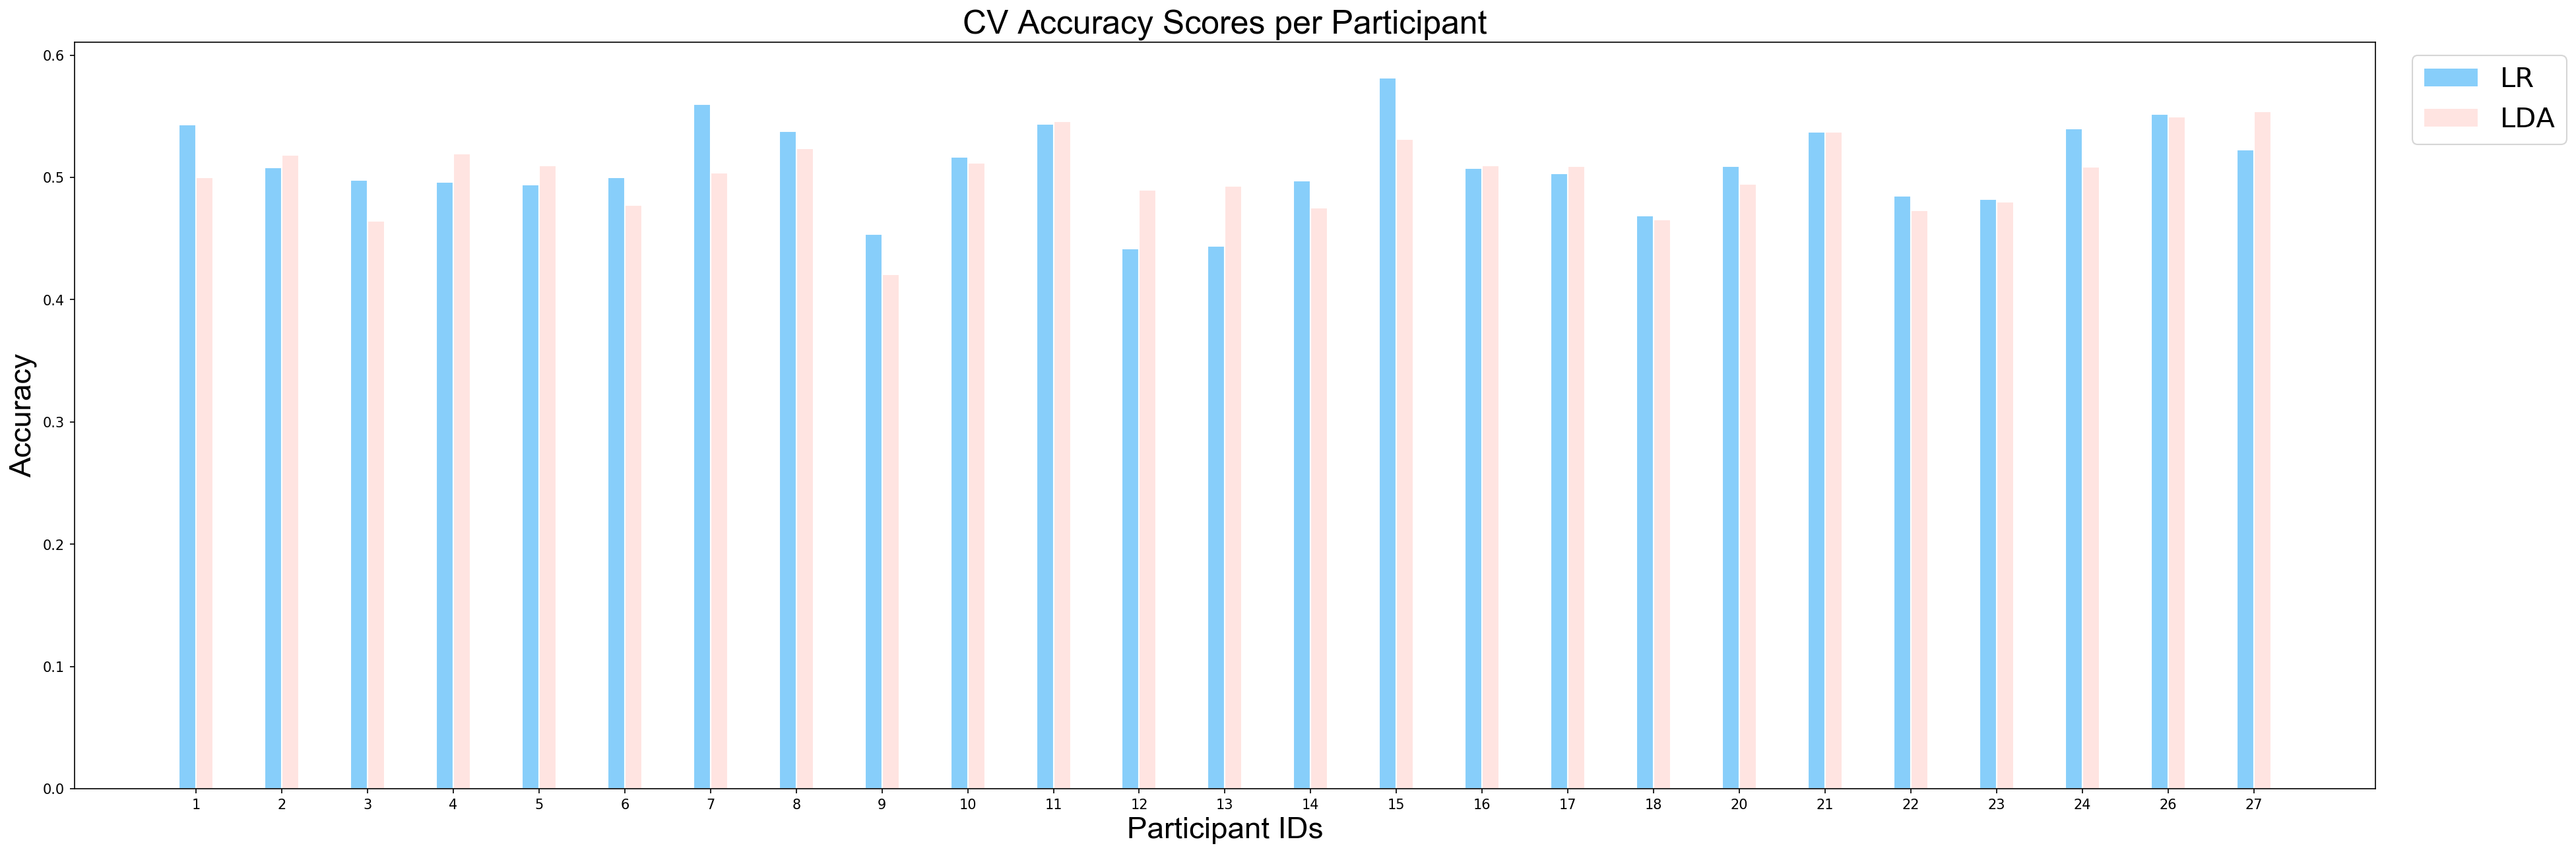

In [13]:
plotCVScores_perParticipant(unique_ids_all, results_perParticipant, model_names)

In [ ]:
plotCVScores_perParticipant(ids_UP, results_eachParticipant, model_names)

 Box plots shows how a given dataset is distributed around the mean of the data and also they highlight outliers:

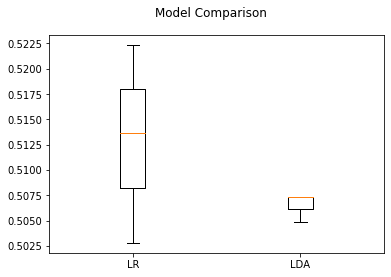

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def plotModelComparison(results, model_names):
    fig = plt.figure()
    fig.suptitle('Model Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(model_names)
    plt.show()
    
plotModelComparison(results, model_names)

Statistical tests are applied to evaluate whether there is a significant difference between the performace of two classifiers. We choose Wilcoxon test which is a paired non-parametric test. Since the same data used for building and testing each classifier, a paired test like Wilcoxon can be applied in our case. We consider as significantly different classification performance where statistical tests give a p-value of p < 0.05:

In [15]:
def applyStatisticalTest(results, model_names):
    if len(results) < 2:
        print('Not enough values for t-test!')
    else:
        for i in range(len(results)):
            for j in range(i+1,len(results)):
                t, p = stats.wilcoxon(results[i],results[j])
                print("p = {0} for wilcoxon test between {1} and {2}".format(p,  model_names[i],  model_names[j]))

In [ ]:
applyStatisticalTest(results, model_names)

Since the derived p-value is larger than 0.05, we can conclude that there is not a significant difference between performance of LDA and performance of LR on the task of classification between unpleasant and pleasant events.

### Example #2:  Classification between Unpleasant and Neutral Events

In [ ]:
# Dataset with unpleasant and neutral events
data_UN, labels_UN, ids_UN = getData_labels(epochs_all_UN)

In [ ]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
models = [ clf_lr_pip, clf_lda_pip]
model_names = [ 'LR', 'LDA']

In [ ]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
results_UN, results_perParticipant_UN = applyCrossValidation(models, model_names, ids_UN, data_UN, labels_UN, kfold)    

In [ ]:
print(results_UN)
mean_CVaccuracies_UN, std_CVaccuracies_UN = [], []

for i in range(len(results_UN)):
    mean_CVaccuracies_UN.append(statistics.mean(results_UN[i]))
    std_CVaccuracies_UN.append(statistics.stdev(results_UN[i]))

mean_CVaccuracies.append(mean_CVaccuracies_UN)
std_CVaccuracies.append(std_CVaccuracies_UN)
print(mean_CVaccuracies)
print(std_CVaccuracies)

In [ ]:
plotModelComparison(results_UN, model_names)

In [ ]:
applyTTest(results_UN, model_names)

Similar as above, since the derived p-value is smaller than 0.05, we can conclude that there is a significant difference between performance of LDA and performance of LR on the task of classification between unpleasant and neutral events.

### Example #3: Classification between Pleasant and Neutral Events

In [ ]:
# Dataset with unpleasant and neutral events
data_NP, labels_NP, ids_NP = getData_labels(epochs_all_NP)

In [ ]:
# Linear Discriminant Analysis
clf_lda_pip = make_pipeline(Vectorizer(), StandardScaler(), LinearDiscriminantAnalysis(solver='svd'))
#Logistic Regression
clf_lr_pip = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression(penalty='l1', random_state=42))
models = [ clf_lr_pip, clf_lda_pip]
model_names = [ 'LR', 'LDA']

In [ ]:
kfold = StratifiedKFold(n_splits=3, random_state=42)
results_NP, results_perParticipant_NP = applyCrossValidation(models, model_names, ids_NP, data_NP, labels_NP, kfold) 

In [ ]:
print(results_NP)
mean_CVaccuracies_NP, std_CVaccuracies_NP = [], []

for i in range(len(results_NP)):
    mean_CVaccuracies_NP.append(statistics.mean(results_NP[i]))
    std_CVaccuracies_NP.append(statistics.stdev(results_NP[i]))

mean_CVaccuracies.append(mean_CVaccuracies_NP)
std_CVaccuracies.append(std_CVaccuracies_NP)
print(mean_CVaccuracies)
print(std_CVaccuracies)

In [ ]:
plotModelComparison(results_NP, model_names)

In [ ]:
applyTTest(results_NP, model_names)

#### Comparing Performance of Models Over Different Tasks

In [ ]:
def plotEvalMetrics(tasks, labels, evalMetric, metricName):
    width = 0.2  # the width of the bars

    # Set position of bar on X axis
    rects1 = np.arange(len(evalMetric))
    rects2 = [x + width for x in rects1]
    rects3 = [x + width for x in rects2]

    plt.bar(rects1, list(zip(*evalMetric))[0], color='#87CEFA', width=width, edgecolor='white', label=labels[0])
    plt.bar(rects2, list(zip(*evalMetric))[1], color='#FFE4E1', width=width, edgecolor='white', label=labels[1])
    
    plt.xlabel('Classification Tasks')
    plt.xticks([r + width/2 for r in range(len(evalMetric))], tasks)
    plt.ylabel(metricName)

    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', )
    plt.show()

In [ ]:
#Plot Mean Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['LDA', 'LR']
plotEvalMetrics(tasks, labels, mean_CVaccuracies, 'Mean CV Accuracy')

In [ ]:
#Plot Std of Accuracies
tasks = ['UN', 'UP', 'NP']
labels = ['LDA', 'LR']
plotEvalMetrics(tasks, labels, std_CVaccuracies, 'Std of CV Accuracies ')

As part of group level analysis of eeg data, LR and LDA are created as in the previous tutorial but this time SVM is omitted because it requires hours to compute given the large amount of data we have at group level. 

The first plot above showed the mean cross validation for both LDA and Logistic Regression on each task. While classifying between Unpleasant and Neutral events, both models provided accuracy around 50% which is the highest score among all tasks. For other two classification tasks, LDA performed better. It can be concluded that classification between Unpleasant and Pleasant events is the most difficult task for the models since both of them provided poor performance.